In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import string
import numpy as np
import scipy as sp
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Pre-Steps:#

###Step 1:
Create a profile with only the basic and generic information. The identity setting is to distinguish it from the commonly seen 20-somethings US profiles. So we can learn later on wether the system is giving results just based on my preferences and search criteria, or it's still customizing the results based on my profile. 
    
* 46 year old man in China (Age, gender and location are requried for registrition)        
I'm looking for:
* Everyone (not gender specific)
* Ages 18-99
* Located anywhere
* For new friends, short-term dating, long-term dating or casual sex  

###Step 2:
Open general browse page and set search criteria.

**Straight Male:**
* Man
* Interested in woman
* Ages 18 to 100 (*Okcupid users must be 18 or older*)
* Located anywhere
* Online in the last month (*active users*)
* Order by special blend 
    
**Straight Female:**
* Woman
* Interested in man
* Ages 18 to 100 (*Okcupid users must be 18 or older*)
* Located anywhere
* Online in the last month (*active users*)
* Order by special blend  
    
**Bisexual All Gender:**
* All genders
* Interested in everyone
* Ages 18 to 100 (*Okcupid users must be 18 or older*)
* Located anywhere
* Online in the last month (*active users*)
* Order by special blend    

###Step 3
Copy the search page URL, and login response cookies to the code.

In [ ]:
# This function did not work for some reasons. I have to manually put my browser cookies.
def getCookies():
	req = requests.post('https://www.okcupid.com/login',\
			data={'login_username': 'uhohcantletyouknow', 'login_password':'uhohcantletyouknow'})
	cookies = req.cookies
	return cookies
cookies = cookies

In [ ]:
# get a maximum of 30 usernames from one search
def getUsernames():
	url = 'http://www.okcupid.com/match?filter1=0,48&filter2=2,100,18&filter3=5,26\
    78400&filter4=1,1&locid=0&timekey=1&matchOrderBy=SPECIAL_BLEND&custom_search=0&\
    fromWhoOnline=0&mygender=m&update_prefs=1&sort_type=0&sa=1&using_saved_search=&count=30'
	page = requests.get(url, cookies = cookies).text
	soup = BeautifulSoup(page, 'html5lib')
	result = soup.find_all('div', {'class':'match_card_wrapper user-not-hidden '})
	roughnames = [i.get('id') for i in result]
	usernames = [re.findall('usr-(.*)-wrapper', i)[0] for i in roughnames]
	return usernames

# repeat the above search multiple times
def getLotsUsernames():
	usernames = []
	for i in range(1000):
        # 1000 pages * 30 usernames per page = about 30,000 usernames
		usernames += getUsernames()
		print 'Scraped', i, 'of 1000 targeted pages.'
	unique = set(usernames)
	print 'Downloaded %d usernames, of which %d are unique.' % (len(usernames), len(unique))
	return unique

# Part I. Scrap usernames and save to files.

###Why?

The usernames are used to generate unique user profile URL. Scraping 300 pages (9,000 usernames not including duplicates) for each gender takes over an hour. Just to be safe, here I saved the scraped usernames into csv files.

*Scraping part is done on my local server for speed purpose.*

* Straight Male Users:
Downloaded **30,000** usernames, of which **20,565** are unique.
Unique percentage: **68.55%**

* Straight Female Users:
Downloaded **30,000** usernames, of which **24,195** are unique.
Unique percentage: **80.65%**

* Bisexual All Gender Users:
Downloaded **300,000** usernames, of which **23,565** are unique.
Unique percentage: **7.855%**

In [ ]:
%%time
usernames = getLotsUsernames()

In [ ]:
usernames = list(usernames)
for i in range(len(usernames)):
    usernames[i] = usernames[i].encode('utf-8')

In [ ]:
# write usernames into new file
def writeUsernames(usernames):
    string = ''
    for i in usernames:
        string += i+'\n'
    with open('usernames.txt', 'w') as f:
        f.write(string)
    print len(usernames), 'of usernames have been written into usernames.txt.'

# rewrite the file with unique usernames if redundancies are found after multiple scraping attempts
def appendUsernames(usernames):
    string = ''
    for i in usernames:
        string += i+'\n'
    with open('usernames.txt', 'a') as f:
        f.write(string)
    print len(usernames), 'of usernames have been added into usernames.txt.'

In [ ]:
appendUsernames(usernames)

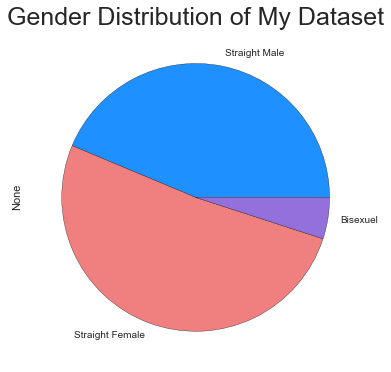

In [2]:
plt.rcParams['figure.figsize'] = 6,6
a = {'Straight Male': 2054, 'Straight Female':2412, 'Bisexuel': 235}
a = pd.Series(a.values(), index = a.keys())
a.plot(kind = 'pie', colors=('dodgerblue','#F08080','mediumpurple'))
plt.title('Gender Distribution of My Dataset', fontsize=25)
figure(figsize=(8,8))

# Part II. Scrap user information from unique profile page

###1. Iterate though the usernames list, and generate unique user profile link.
Number of total profiles scraped:

Straight Male:
2,054  

Straight Female:
2,412  

Bisexual All Gender:
782

###2. Three groups of user infromation:
    
    --User basic information: gender, age, location, orientation, ethnicities, height, bodytype, diet, smoking, drinking, drugs, religion, sign, education, job, income, status, monogamous, children, pets, languages
    
    --User matching information: gender orientation, age range, location, single, purpose
    
    --User self-description: summary, what they are currently doing, what they are good at, noticeable facts, favourite books/movies, things they can’t live without, how to spend time, friday activities, private thing, message preference

###3. Contents are stored in a dictionary, which is converted to a pandas DataFrame and then exported to a csv file.

In [ ]:
def getProfile(num, username):
	result = {}
	for num in range(num):
		url = 'http://www.okcupid.com/profile/'+username[num]
		test = requests.get(url, cookies = cookies)
		if test.status_code == 200:
			page = requests.get(url, cookies=cookies).text
			soup = BeautifulSoup(page)

			# user basic information
			result.setdefault('username', [])
			result.setdefault('gender', [])
			result.setdefault('age', [])
			result.setdefault('location', [])
			result.setdefault('frequency', [])
			result['username'].append(username[num])
			result['gender'].append(soup.find_all('span',{'class':'ajax_gender'})[0].get_text())
			result['age'].append(soup.find_all('span',{'id':'ajax_age'})[0].get_text())
			result['location'].append(soup.find_all('span',{'id':'ajax_location'})[0].get_text())
			result['frequency'].append(soup.find_all('div',{'class':'tooltip_text hidden'})[0].get_text())
                                       
			basic = ['orientation','ethnicities','height','bodytype','diet','smoking',\
			'drinking','drugs','religion','sign','education','job','income','status',\
			'monogamous','children', 'pets','languages']
			for i in basic:
				result.setdefault(i, [])
				x = soup.find_all('dd', {'id':'ajax_'+i})
				if x == []:
					result[i].append('')
				else:
					result[i].append(x[0].get_text())

			# user matching information
			find = ['gentation','ages','near','single','lookingfor']
			for i in find:
				result.setdefault(i, [])
				x = soup.find_all('li', {'id':'ajax_'+i})
				if x == []:
					result[i].append('')
				else:
					result[i].append(x[0].get_text())

			# user self description information
			text = ['0','1','2','3','4','5','6','7','8','9']
			for i in text:
				result.setdefault(i, [])
				x = soup.find_all('div', {'id':'essay_text_'+i})
				if x == []:
					result[i].append('')
				else:
					result[i].append(x[0].get_text())

		print num, 'of', len(username), test.status_code == 200
	return result

In [ ]:
l =[]
with open('usernames.txt', 'r') as f:
    for line in f:
        l.append(line.rstrip('\n'))
s = set(l)
print len(l), 'of usernames have been added to the usernames list.'
print len(s), "of them are unique."

# rewrite the file if there were redundancies
if len(l) != len(s):
    writeUsernames(s)
    print 'usernames.txt file has been rewrriten.'
    
l = list(s)

In [ ]:
# Set the number of usernames to scrape
result = getProfile(len(l), l)
profile = pd.DataFrame(result)
profile = profile.rename(columns = {'0':'0summary','1':'1doing','2':'2goodat','3':'3notice',\
	'4':'4books','5':'5without','6':'6spendtime','7':'7friday','8':'8private','9':'9message'})
profile = profile.set_index(['username'])
print profile.columns

In [ ]:
# Export the profiles to csv
profile.to_csv('profile.csv',encoding='utf-8')
!head -5 profile.csv

In [ ]:
profile

# Part III. Data analysis

###1. Upload saved straight male, straight female, and bisexual profile csv files to pandas datafram for data manipulation.

###2. Demographics Analysis
* How old are they? Age distribution of each group.
* Where are they located? Top locations of each group.

###3. Psychological Analysis
* Who are pickier? Age ranges set by different groups of users compared to their own ages.
* Who are possibly lying? Average height of different groups of users compared to CDC data.

###4. Notes
* The user age distributions observed are much older than other online reports. This is possibly affected by the login profile setting. I've set my robot profile as a 46 year old man located in China. From this we can learn that the system is still using my profile setting as a refrence, even if I've indicated that I'm open to people from all ages.
* The factors contributing to the height differences could also be: 1) Biased data collection. 2) People who use Okcupid really are taller than the average!

In [3]:
p = pd.read_table('profiles(male).csv', sep=',')
p.groupby([p.gender]).size()

gender
Man                                          2053
Man, Genderfluid, Genderqueer, Non-binary       1
dtype: int64

In [4]:
p2 = pd.read_table('profiles(female).csv', sep=',')
p2.groupby([p2.gender]).size()

gender
Agender                                                          1
Cis Woman                                                        1
Genderfluid, Woman, Non-binary, Agender                          1
Non-binary                                                       1
Transfeminine, Woman, Transgender, Non-binary, Trans Woman       1
Transgender                                                      1
Transgender, Transsexual, Woman                                  1
Woman                                                         2405
dtype: int64

In [5]:
p3 = pd.read_table('profile.csv', sep=',')
p3.groupby([p3.gender]).size()

gender
Agender                                                1
Agender, Genderfluid                                   1
Agender, Genderqueer                                   1
Androgynous                                            1
Androgynous, Non-binary                                1
Androgynous, Woman                                     1
Cis Man                                                1
Cis Woman                                              5
Gender Nonconforming                                   2
Genderfluid                                            3
Genderfluid, Genderqueer                               1
Genderfluid, Man                                       1
Genderqueer                                            4
Genderqueer, Gender Nonconforming, Non-binary          1
Genderqueer, Genderfluid                               1
Man                                                  146
Man, Agender                                           1
Man, Cis Man            

Populating the interactive namespace from numpy and matplotlib


The average age of 2054 staright female users is 44.0


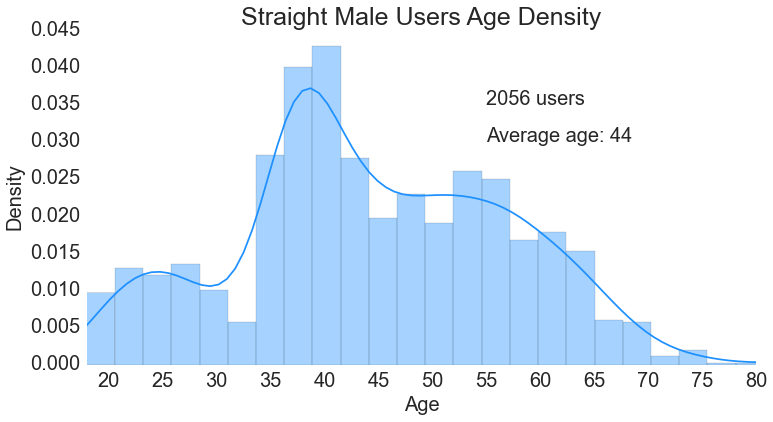

In [6]:
%pylab inline
plt.rcParams['figure.figsize'] = 12, 6
sns.distplot(p.age, color = "dodgerblue")
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.xticks(np.arange(20,85,5), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(18,80)
plt.title('Straight Male Users Age Density', fontsize = 25)
plt.text(55, 0.035, '2056 users', fontsize = 20)
plt.text(55, 0.03, 'Average age: 44', fontsize = 20)
print '\n\n','The average age of', len(p), 'staright female users is', round(mean(p.age))



The average age of 2412 staright female users is 35.0


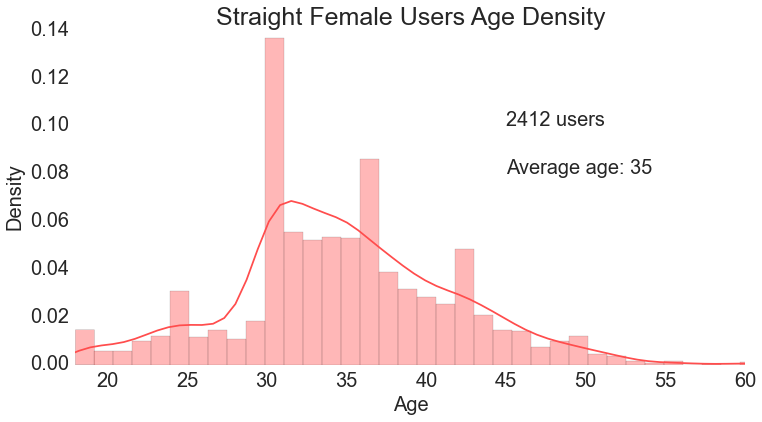

In [7]:
plt.rcParams['figure.figsize'] = 12, 6
sns.distplot(p2.age, color = '#FF4D4D')
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.xticks(np.arange(20,85,5), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(18,60)
plt.title('Straight Female Users Age Density', fontsize = 25)
plt.text(45, 0.10, '2412 users', fontsize = 20)
plt.text(45, 0.08, 'Average age: 35', fontsize = 20)
print '\n\n','The average age of', len(p2), 'staright female users is', round(mean(p2.age))



The average age of 782 staright female users is 26.0


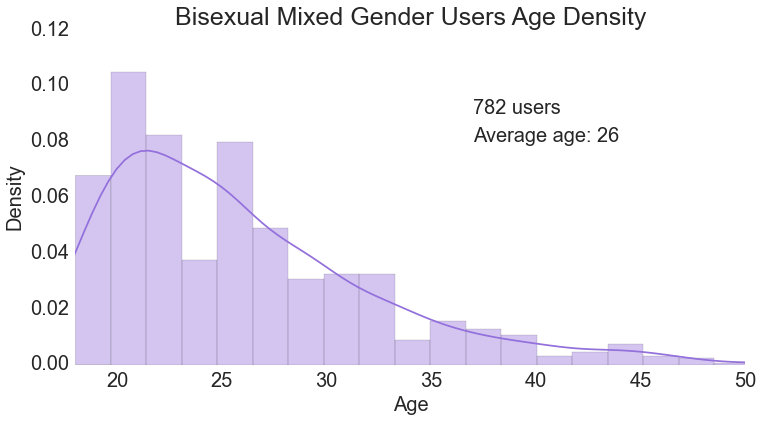

In [8]:
plt.rcParams['figure.figsize'] = 12, 6
sns.distplot(p3.age, color = 'mediumpurple')
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.xticks(np.arange(20,85,5), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(18,50)
plt.title('Bisexual Mixed Gender Users Age Density', fontsize = 25)
plt.text(37, 0.09, '782 users', fontsize = 20)
plt.text(37, 0.08, 'Average age: 26', fontsize = 20)
print '\n\n','The average age of', len(p3), 'staright female users is', round(mean(p3.age))

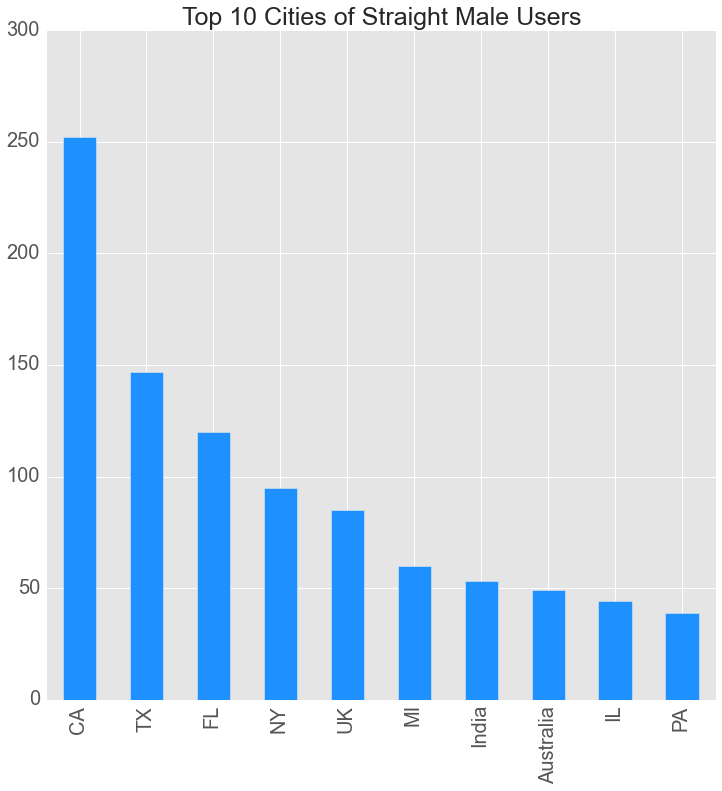

In [11]:
def locationranks(df):
    ranks = {}
    for i in df.location:
        x = re.split(', ', i)[-1]
        ranks[x] = ranks.get(x, 0) + 1
    ranks = pd.Series(ranks.values(), index = ranks.keys())
    ranks = ranks.order(ascending=False)[:10]
    return ranks

plt.rcParams['figure.figsize'] = 12,12
locationranks(p).plot(kind='bar', fontsize = 14, legend=False, color = 'dodgerblue')
plt.title('Top 10 Cities of Straight Male Users', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.style.use('ggplot')

(array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.]),
 <a list of 9 Text yticklabel objects>)

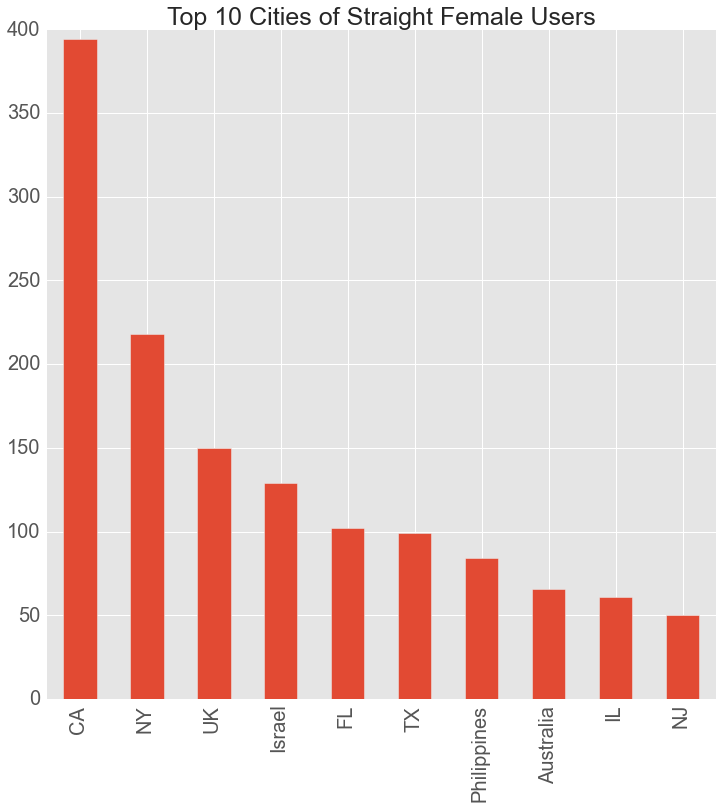

In [10]:
plt.rcParams['figure.figsize'] = 12,12
locationranks(p2).plot(kind = 'bar', fontsize = 14, legend=False)
plt.title('Top 10 Cities of Straight Female Users', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.]),
 <a list of 8 Text yticklabel objects>)

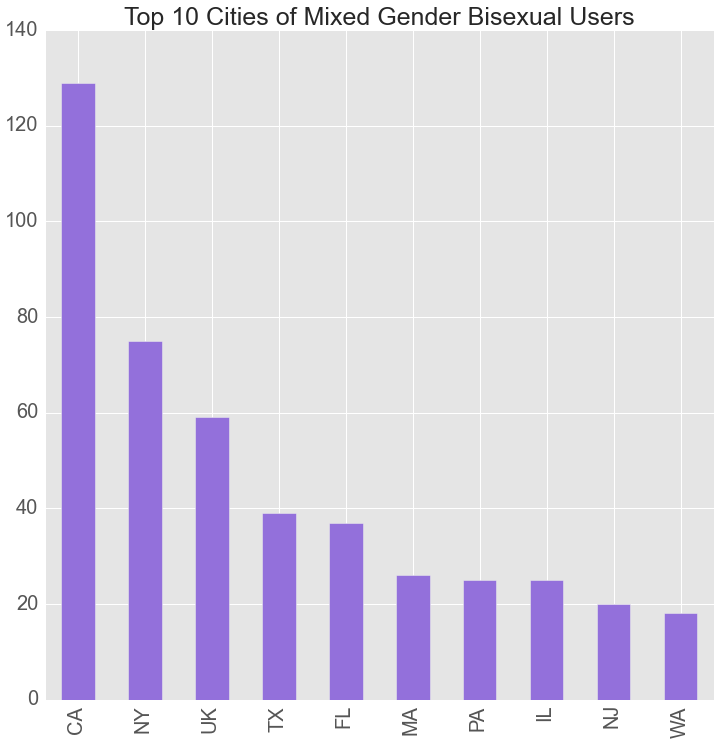

In [12]:
plt.rcParams['figure.figsize'] = 12,12
locationranks(p3).plot(kind = 'bar', fontsize = 14, legend=False, color = 'mediumpurple')
plt.title('Top 10 Cities of Mixed Gender Bisexual Users', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

2054


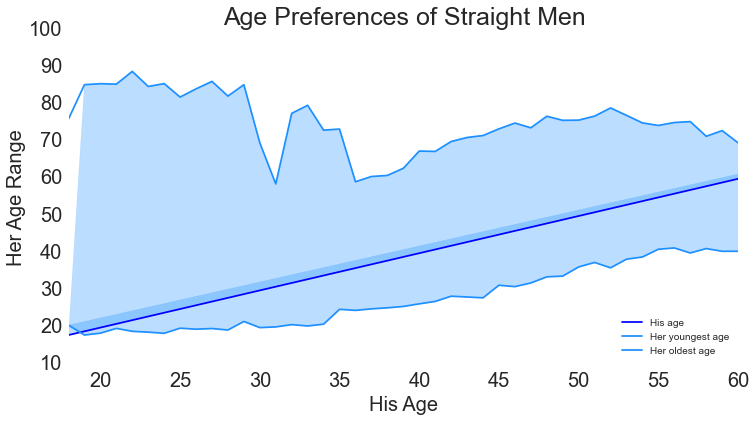

In [9]:
young = []
old = []
for i in p.index:
    y = int(re.findall('(\d\d)–', p.ages[i])[0])
    o = int(re.findall('–(\d\d)', p.ages[i])[0])
    young.append(y)
    old.append(o)
young = pd.Series(young)
old = pd.Series(old)
agerange = pd.DataFrame(p.age, columns=['age'])
agerange['young'] = young
agerange['old'] = old
print len(agerange)

plt.rcParams['figure.figsize'] = 12, 6
plot = agerange.groupby(agerange.age).mean()
plt.plot(plot.index, plot.index, color='blue', label = 'His age')
plt.plot(plot.index, plot.young, color='dodgerblue', label = 'Her youngest age')
plt.plot(plot.index, plot.old, color='dodgerblue', label = 'Her oldest age')
plot.old[18] = 18
plot.young[99] = 99
plt.fill(plot.index, plot.old, color='dodgerblue', alpha = 0.3)
plt.fill(plot.index, plot.young, color='dodgerblue', alpha = 0.3)
plt.xlabel('His Age', fontsize = 20)
plt.ylabel('Her Age Range', fontsize = 20)
plt.xticks(np.arange(20,85,5), fontsize=20)
plt.yticks(fontsize=20)
plt.title('Age Preferences of Straight Men', fontsize = 25)
plt.xlim(18,60)
plt.legend(loc = 4)

2412


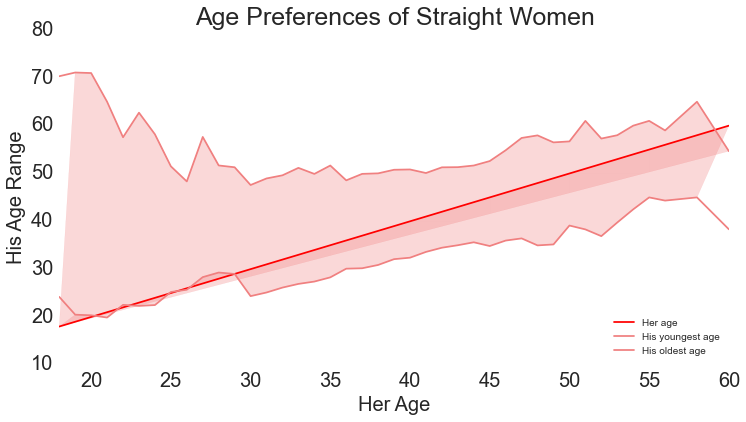

In [10]:
young = []
old = []
for i in p2.index:
    y = int(re.findall('(\d\d)–', p2.ages[i])[0])
    o = int(re.findall('–(\d\d)', p2.ages[i])[0])
    young.append(y)
    old.append(o)
young = pd.Series(young)
old = pd.Series(old)
agerange = pd.DataFrame(p2.age, columns=['age'])
agerange['young'] = young
agerange['old'] = old
print len(agerange)
plot = agerange.groupby(agerange.age).mean()
plot = plot.loc[plot.index <= 60,]

plt.rcParams['figure.figsize'] = 12, 6
plt.plot(plot.index, plot.index, color='red', label = 'Her age')
plt.plot(plot.index, plot.young, color='#F08080', label = 'His youngest age')
plt.plot(plot.index, plot.old, color='#F08080', label = 'His oldest age')
plot.loc[18] = 18
plot.young[60] = 60
plt.fill(plot.index, plot.old, color='#F08080', alpha = 0.3)
plt.fill(plot.index, plot.young, color='#F08080', alpha = 0.3)
plt.xlabel('Her Age', fontsize = 20)
plt.ylabel('His Age Range', fontsize = 20)
plt.xticks(np.arange(20,85,5), fontsize=20)
plt.yticks(fontsize=20)
plt.title('Age Preferences of Straight Women', fontsize = 25)
plt.xlim(18,60)
plt.legend(loc = 4)

782


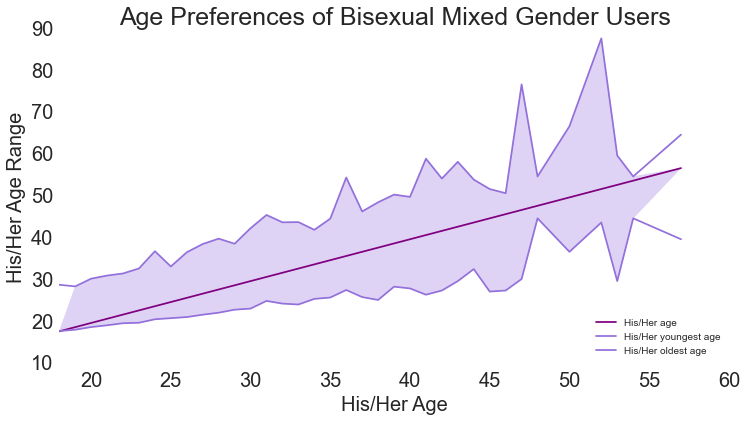

In [11]:
young = []
old = []
for i in p3.index:
    y = int(re.findall('(\d\d)–', p3.ages[i])[0])
    o = int(re.findall('–(\d\d)', p3.ages[i])[0])
    young.append(y)
    old.append(o)
young = pd.Series(young)
old = pd.Series(old)
agerange = pd.DataFrame(p3.age, columns=['age'])
agerange['young'] = young
agerange['old'] = old
print len(agerange)
plot = agerange.groupby(agerange.age).mean()
plot = plot.loc[plot.index <= 60,]

plt.rcParams['figure.figsize'] = 12, 6
plt.plot(plot.index, plot.index, color='purple', label = 'His/Her age')
plt.plot(plot.index, plot.young, color='mediumpurple', label = 'His/Her youngest age')
plt.plot(plot.index, plot.old, color='mediumpurple', label = 'His/Her oldest age')
plot.loc[18] = 18
plot.old[57] = 57
plot.young[57] = 57
plt.fill(plot.index, plot.old, color='mediumpurple', alpha = 0.3)
plt.fill(plot.index, plot.young, color='mediumpurple', alpha = 0.3)
plt.xlabel('His/Her Age', fontsize = 20)
plt.ylabel('His/Her Age Range', fontsize = 20)
plt.xticks(np.arange(20,85,5), fontsize=20)
plt.yticks(fontsize=20)
plt.title('Age Preferences of Bisexual Mixed Gender Users', fontsize = 25)
plt.xlim(18,60)
plt.legend(loc = 4)

Populating the interactive namespace from numpy and matplotlib
1239


`%matplotlib` prevents importing * from pylab and numpy


(145, 210)

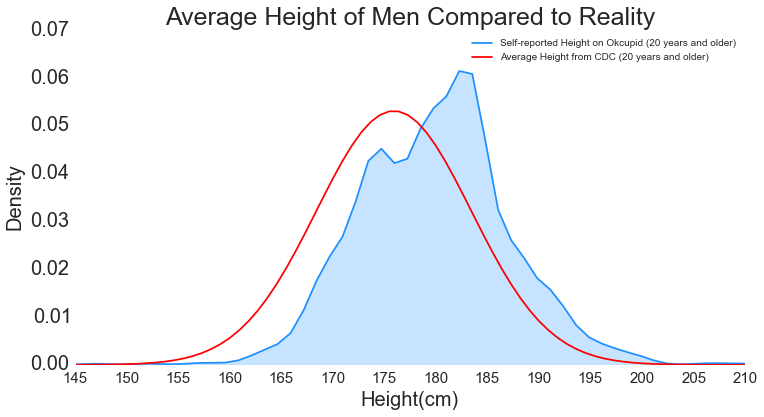

In [12]:
%pylab inline
man = p[(p.gender == 'Man') & (p.age >= 20)]
lst=[]
count = 0
for i in man.height:
    if type(i) == str:
        lst.append(int(float(re.findall('(\d.\d\d)m', i)[0])*100))
        count += 1
print count
lst = pd.Series(lst)

plt.rcParams['figure.figsize'] = 12, 6
sns.kdeplot(lst, shade=True, label='Self-reported Height on Okcupid (20 years and older)', color = 'dodgerblue')
seq = np.linspace(130,220,100)
plt.plot(seq, stats.norm.pdf(seq, loc =175.9, scale = np.sqrt(5647)*0.2/2), color='red', label = 'Average Height from CDC (20 years and older)')
plt.legend(loc = 1)
plt.xticks(np.arange(140,220,5), fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Height(cm)', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.title('Average Height of Men Compared to Reality', fontsize = 25)
plt.xlim(18,60)
plt.legend(loc = 1)
plt.xlim(145, 210)

1670


(140, 210)

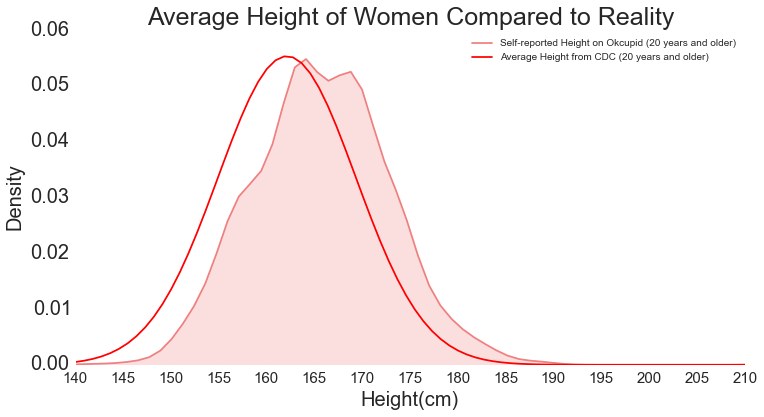

In [13]:
woman = p2[(p2.gender == 'Woman') & (p2.age >= 20)]
lst=[]
count = 0
for i in woman.height:
    if type(i) == str:
        lst.append(int(float(re.findall('(\d.\d\d)m', i)[0])*100))
        count += 1
print count
lst = pd.Series(lst)

plt.rcParams['figure.figsize'] = 12, 6
sns.kdeplot(lst, shade=True, label='Self-reported Height on Okcupid (20 years and older)', color = '#F08080')
seq = np.linspace(130,220,100)
plt.plot(seq, stats.norm.pdf(seq, loc =162.1, scale = np.sqrt(5971)*0.14/1.5), color='red', label = 'Average Height from CDC (20 years and older)')
plt.legend(loc = 1)
plt.xticks(np.arange(140,220,5), fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Height(cm)', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.title('Average Height of Women Compared to Reality', fontsize = 25)
plt.xlim(18,60)
plt.legend(loc = 1)
plt.xlim(140, 210)

In [ ]:
# Add latitude and longitude information on each profile based on the city location
%time
latitude = []
longitude = []
for i in p2.index:
    print i, 'of', len(p2.index), 'finished.'
    geolocator = Nominatim()
    try:
        location = geolocator.geocode(p2.location[i])
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append(0)
        longitude.append(0)
p2['latitude'] = latitude
p2['longitude'] = longitude
p2.head()

In [27]:
p2.to_csv('profile(female)geo.csv',encoding='utf-8')

In [14]:
# Below are word count functions that I keep it here for later text analysis
def wordCount(raw, punctuation='\n', ignoreCase = True):
    raw = raw.lower()
    for i in string.punctuation:
        raw = raw.replace(i, '')
    if punctuation != None:
        for i in punctuation:
            raw = raw.replace(i, ' ')
    raw_list = raw.split()
    result = {}
    for word in raw_list:
        result[word] = result.get(word, 0) + 1
    return result
    
def wordCountSort(raw, descend = True, punctuation='\n', ignoreCase = True):
    result = wordCount(raw, punctuation=punctuation, ignoreCase = ignoreCase)
    result = sorted(result.items(), key = lambda x: x[1] , reverse = descend)
    return result
    
def mostCommonWord(raw, num=5, punctuation='\n', descend = True, ignoreCase = True):
    result = wordCountSort(raw, punctuation=punctuation, ignoreCase = ignoreCase, descend = descend)
    if num > len(result):
        Warning('There are only %s words'%len(result))
        return result
    else:
        return result[:num]